In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
# from helper_functions import set_seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Define the class names
class_names = ['glioma','meningioma', 'notumor', 'pituitary']

# Function to setup the model
def setup_model(weights, device, class_names):
    # Setup a ViT model instance with pretrained weights
    model = torchvision.models.vit_b_16(weights=weights).to(device)

    # Freeze the base parameters
    freeze_parameters(model)

    # Change the classifier head
    change_classifier_head(model, class_names, device)

    return model

# Function to freeze parameters
def freeze_parameters(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

# Function to change the classifier head
def change_classifier_head(model, class_names, device):
    model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Function to set seeds
def set_seeds():
    # Add your seed setting code here
    pass

# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup the model
set_seeds()
pretrained_vit = setup_model(pretrained_vit_weights, device, class_names)

In [4]:
from torchinfo import summary

# Function to print model summary
def print_model_summary(model, input_size, col_names, col_width, row_settings):
    summary(model=model,
            input_size=input_size,
            col_names=col_names,
            col_width=col_width,
            row_settings=row_settings)

# Define the parameters for the summary
input_size = (32, 3, 224, 224) # (batch_size, color_channels, height, width)
col_names = ["input_size", "output_size", "num_params", "trainable"]
col_width = 20
row_settings = ["var_names"]

# Print the summary
print_model_summary(pretrained_vit, input_size, col_names, col_width, row_settings)

In [5]:
# Setup directory paths to train and test images
train_dir = "/home/usd.local/neerajdattu.dudam/rizk_lab/shared/neerajdattu/dataset/Training"
test_dir = "/home/usd.local/neerajdattu.dudam/rizk_lab/shared/neerajdattu/dataset/Testing"

In [6]:
# Function to get and print transforms from pretrained weights
def get_and_print_transforms(weights):
    transforms = weights.transforms()
    print(transforms)
    return transforms

# Get and print the transforms
pretrained_vit_transforms = get_and_print_transforms(pretrained_vit_weights)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Function to create a data loader
def create_dataloader(data, batch_size, shuffle, num_workers):
    return DataLoader(
        data,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True,
    )

# Function to create a dataset
def create_dataset(dir, transform):
    return datasets.ImageFolder(dir, transform=transform)

# Function to create data loaders
def create_data_loaders(train_dir, test_dir, transform, batch_size):
    num_workers = os.cpu_count()

    # Create datasets
    train_data = create_dataset(train_dir, transform)
    test_data = create_dataset(test_dir, transform)

    # Get class names
    class_names = train_data.classes

    # Create data loaders
    train_dataloader = create_dataloader(train_data, batch_size, True, num_workers)
    test_dataloader = create_dataloader(test_data, batch_size, False, num_workers)

    return train_dataloader, test_dataloader, class_names

In [8]:
# Function to setup data loaders
def setup_data_loaders(train_dir, test_dir, transform, batch_size):
    return create_data_loaders(train_dir, test_dir, transform, batch_size)

# Define the parameters for the data loaders
train_dir = train_dir
test_dir = test_dir
transform = pretrained_vit_transforms
batch_size = 32

# Setup the data loaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = setup_data_loaders(train_dir, test_dir, transform, batch_size)

In [10]:
import engine
import torch.optim as optim
import torch.nn as nn

# Function to create optimizer
def create_optimizer(model, lr):
    return optim.Adam(params=model.parameters(), lr=lr)

# Function to create loss function
def create_loss_fn():
    return nn.CrossEntropyLoss()

# Function to train model
def train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    set_seeds()
    return engine.train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=epochs,
                        device=device)

# Create optimizer and loss function
optimizer = create_optimizer(pretrained_vit, 1e-3)
loss_fn = create_loss_fn()

# Train the model
pretrained_vit_results = train_model(pretrained_vit, train_dataloader_pretrained, test_dataloader_pretrained, optimizer, loss_fn, 30, device)

  3%|▎         | 1/30 [04:01<1:56:51, 241.79s/it]

Epoch: 1 | train_loss: 0.3140 | train_acc: 0.8912 | test_loss: 0.3211 | test_acc: 0.8788


  7%|▋         | 2/30 [08:01<1:52:17, 240.62s/it]

Epoch: 2 | train_loss: 0.2245 | train_acc: 0.9234 | test_loss: 0.2692 | test_acc: 0.8986


 10%|█         | 3/30 [12:03<1:48:34, 241.29s/it]

Epoch: 3 | train_loss: 0.1909 | train_acc: 0.9342 | test_loss: 0.2358 | test_acc: 0.9207


 13%|█▎        | 4/30 [16:03<1:44:20, 240.78s/it]

Epoch: 4 | train_loss: 0.1678 | train_acc: 0.9461 | test_loss: 0.2191 | test_acc: 0.9146


 17%|█▋        | 5/30 [19:58<1:39:26, 238.65s/it]

Epoch: 5 | train_loss: 0.1513 | train_acc: 0.9495 | test_loss: 0.2067 | test_acc: 0.9192


 20%|██        | 6/30 [23:57<1:35:29, 238.72s/it]

Epoch: 6 | train_loss: 0.1393 | train_acc: 0.9562 | test_loss: 0.1847 | test_acc: 0.9329


 23%|██▎       | 7/30 [27:58<1:31:50, 239.61s/it]

Epoch: 7 | train_loss: 0.1311 | train_acc: 0.9565 | test_loss: 0.1722 | test_acc: 0.9390


 27%|██▋       | 8/30 [31:51<1:27:01, 237.32s/it]

Epoch: 8 | train_loss: 0.1175 | train_acc: 0.9640 | test_loss: 0.1657 | test_acc: 0.9383


 30%|███       | 9/30 [35:48<1:23:03, 237.29s/it]

Epoch: 9 | train_loss: 0.1118 | train_acc: 0.9663 | test_loss: 0.1617 | test_acc: 0.9413


 33%|███▎      | 10/30 [40:13<1:21:55, 245.75s/it]

Epoch: 10 | train_loss: 0.1042 | train_acc: 0.9677 | test_loss: 0.1477 | test_acc: 0.9497


 37%|███▋      | 11/30 [44:23<1:18:17, 247.23s/it]

Epoch: 11 | train_loss: 0.0989 | train_acc: 0.9714 | test_loss: 0.1589 | test_acc: 0.9428


 40%|████      | 12/30 [48:31<1:14:12, 247.35s/it]

Epoch: 12 | train_loss: 0.0936 | train_acc: 0.9740 | test_loss: 0.1479 | test_acc: 0.9444


 43%|████▎     | 13/30 [52:38<1:10:05, 247.39s/it]

Epoch: 13 | train_loss: 0.0892 | train_acc: 0.9754 | test_loss: 0.1356 | test_acc: 0.9566


 47%|████▋     | 14/30 [56:38<1:05:19, 245.00s/it]

Epoch: 14 | train_loss: 0.0845 | train_acc: 0.9759 | test_loss: 0.1304 | test_acc: 0.9573


 50%|█████     | 15/30 [1:00:38<1:00:51, 243.43s/it]

Epoch: 15 | train_loss: 0.0808 | train_acc: 0.9780 | test_loss: 0.1327 | test_acc: 0.9535


 53%|█████▎    | 16/30 [1:04:35<56:21, 241.51s/it]  

Epoch: 16 | train_loss: 0.0763 | train_acc: 0.9813 | test_loss: 0.1238 | test_acc: 0.9627


 57%|█████▋    | 17/30 [1:08:34<52:11, 240.85s/it]

Epoch: 17 | train_loss: 0.0745 | train_acc: 0.9785 | test_loss: 0.1159 | test_acc: 0.9649


 60%|██████    | 18/30 [1:12:33<48:03, 240.28s/it]

Epoch: 18 | train_loss: 0.0708 | train_acc: 0.9820 | test_loss: 0.1128 | test_acc: 0.9642


 63%|██████▎   | 19/30 [1:16:36<44:13, 241.19s/it]

Epoch: 19 | train_loss: 0.0687 | train_acc: 0.9825 | test_loss: 0.1256 | test_acc: 0.9588


 67%|██████▋   | 20/30 [1:20:36<40:07, 240.73s/it]

Epoch: 20 | train_loss: 0.0644 | train_acc: 0.9852 | test_loss: 0.1114 | test_acc: 0.9611


 70%|███████   | 21/30 [1:24:35<36:03, 240.35s/it]

Epoch: 21 | train_loss: 0.0629 | train_acc: 0.9841 | test_loss: 0.1046 | test_acc: 0.9657


 73%|███████▎  | 22/30 [1:28:39<32:10, 241.28s/it]

Epoch: 22 | train_loss: 0.0623 | train_acc: 0.9848 | test_loss: 0.1048 | test_acc: 0.9688


 77%|███████▋  | 23/30 [1:32:31<27:50, 238.61s/it]

Epoch: 23 | train_loss: 0.0570 | train_acc: 0.9867 | test_loss: 0.1125 | test_acc: 0.9634


 80%|████████  | 24/30 [1:36:26<23:44, 237.41s/it]

Epoch: 24 | train_loss: 0.0560 | train_acc: 0.9878 | test_loss: 0.1063 | test_acc: 0.9642


 83%|████████▎ | 25/30 [1:40:26<19:51, 238.21s/it]

Epoch: 25 | train_loss: 0.0534 | train_acc: 0.9897 | test_loss: 0.1135 | test_acc: 0.9642


 87%|████████▋ | 26/30 [1:44:30<15:59, 239.99s/it]

Epoch: 26 | train_loss: 0.0519 | train_acc: 0.9895 | test_loss: 0.0955 | test_acc: 0.9703


 90%|█████████ | 27/30 [1:48:28<11:58, 239.52s/it]

Epoch: 27 | train_loss: 0.0505 | train_acc: 0.9892 | test_loss: 0.0908 | test_acc: 0.9695


 93%|█████████▎| 28/30 [1:52:22<07:55, 237.65s/it]

Epoch: 28 | train_loss: 0.0481 | train_acc: 0.9902 | test_loss: 0.0896 | test_acc: 0.9726


 97%|█████████▋| 29/30 [1:56:21<03:57, 238.00s/it]

Epoch: 29 | train_loss: 0.0471 | train_acc: 0.9907 | test_loss: 0.0878 | test_acc: 0.9771


100%|██████████| 30/30 [2:00:15<00:00, 240.53s/it]

Epoch: 30 | train_loss: 0.0452 | train_acc: 0.9907 | test_loss: 0.0912 | test_acc: 0.9726


In [12]:
import pickle

# Dump the model to a file
with open('modelb16.pkl', 'wb') as f:
    pickle.dump(pretrained_vit, f)
    
# Dump the test dataloader to a file
with open('modelb16_test.pkl', 'wb') as f:
    pickle.dump(test_dataloader_pretrained, f)

# Dump the results to a file
with open('modelb16_results.pkl', 'wb') as f:
    pickle.dump(pretrained_vit_results, f)

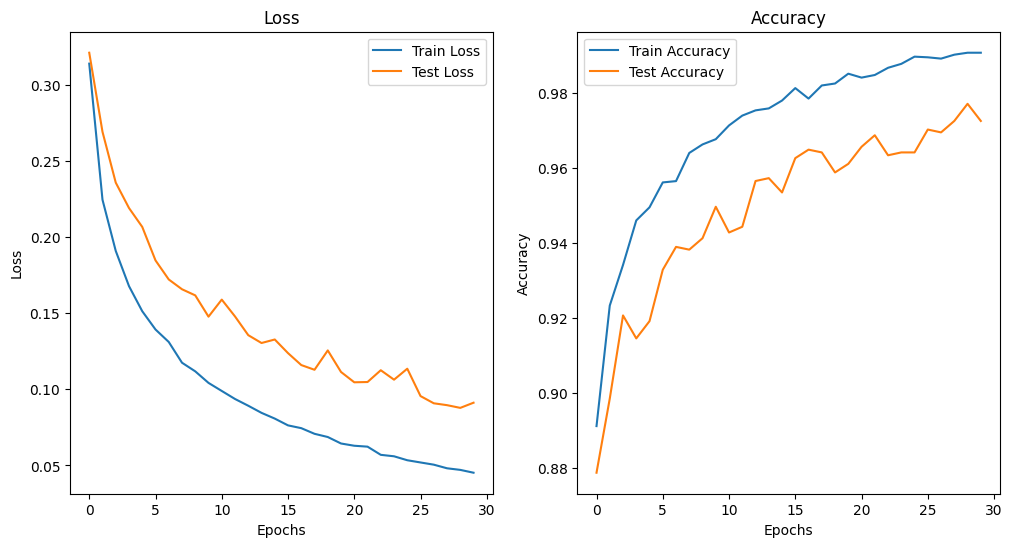

In [29]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    # Extract values from results dictionary
    train_loss = results['train_loss']
    test_loss = results['test_loss']
    train_acc = results['train_acc']
    test_acc = results['test_acc']
    
    epochs = range(len(train_loss))
    
    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, test_acc, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Call the function to plot the curves
plot_loss_curves(pretrained_vit_results)


              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.93      0.97      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



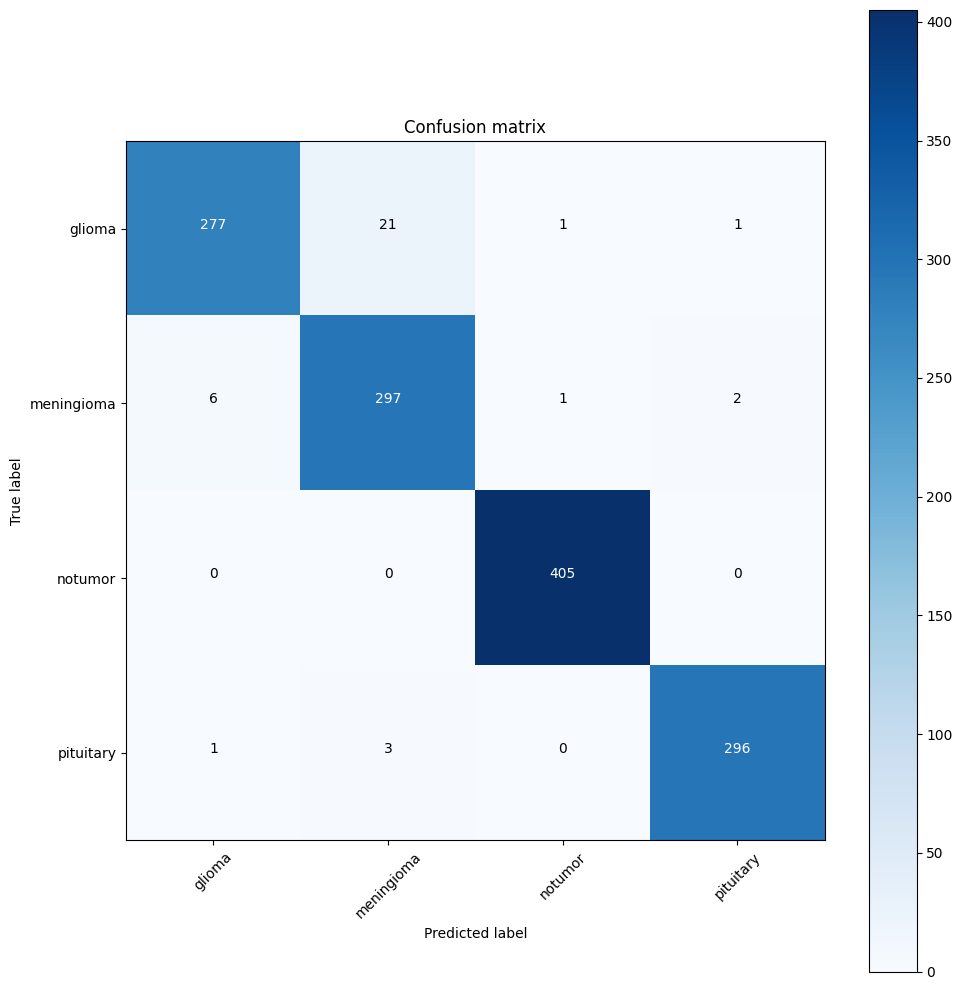

In [30]:
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

test_dir = "/home/usd.local/sonyreddy.gurram/rizk_lab/shared/neeraj_dattu/dataset/Testing"


def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    return true_labels, pred_labels

# Get true and predicted labels
true_labels, pred_labels = evaluate_model(pretrained_vit, test_dataloader_pretrained, device)

# Print classification report
print(classification_report(true_labels, pred_labels, target_names=class_names))

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix as a color grid
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

# Add labels to the plot
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add numbers to the grid
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()